In [8]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from models import *
from targets import *
from utils import *

In [31]:
prior = torch.distributions.MultivariateNormal(torch.ones(1), torch.eye(1))

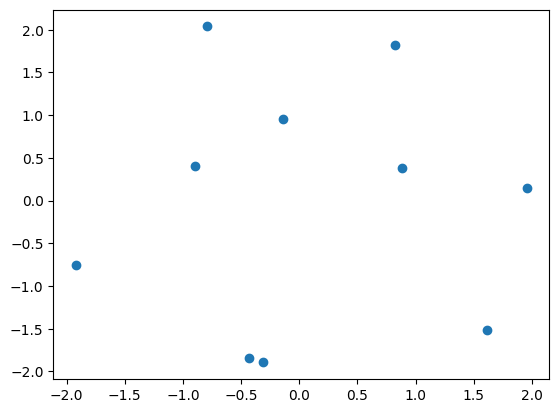

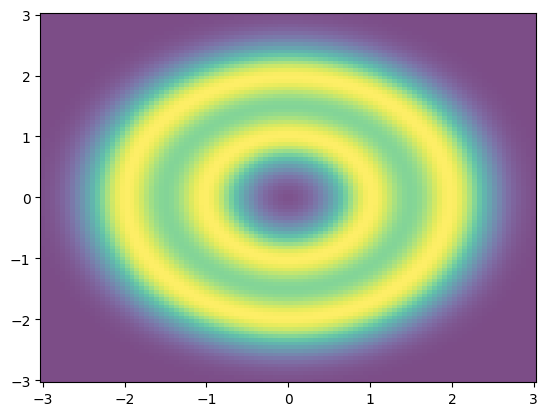

In [33]:
N_0 = 10
theta_0 = torch.tensor([1.])
x_0 = target.sample(theta_0.unsqueeze(0).repeat(N_0,1))
plot_2d_points(x_0)
plt.show()
plot_2d_function(lambda x: torch.exp(target.log_prob(x,theta_0.unsqueeze(0).repeat(x.shape[0],1))), range = [[-3,3],[-3,3]], bins =[100,100])
plt.show()

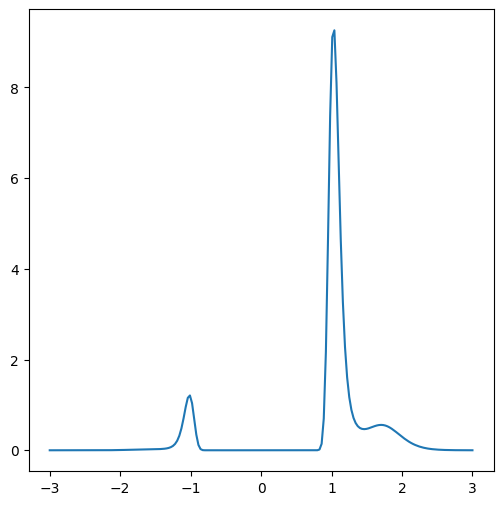

In [43]:
true_posterior_log_prob = lambda theta: prior.log_prob(theta) + torch.sum(target.log_prob(x_0.unsqueeze(0).repeat(theta.shape[0],1,1), theta.unsqueeze(1).repeat(1, N_0,1)), dim = 1)
plt.figure(figsize = (6,6))
plot_1d_unormalized_function(lambda theta : torch.exp(true_posterior_log_prob(theta.unsqueeze(-1))).detach(), range = [-3,3], bins = 500)
plt.show()

In [35]:
dif = ConditionalDIF(D_x, D_theta, 50,[64,64])
dif.train(200,1000, lr = 5e-3)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [04:55<00:00,  1.48s/it, loss = 0.348045 ; device: cpu]


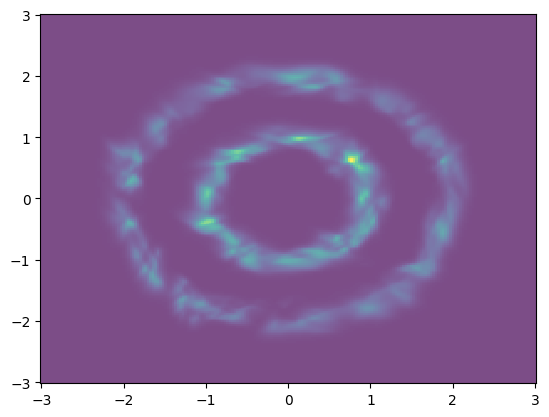

In [39]:
plot_2d_function(lambda x: torch.exp(dif.log_prob(x,theta_0.unsqueeze(0).repeat(x.shape[0],1))), range = [[-3,3],[-3,3]], bins =[200,200])
plt.show()

In [41]:
posterior_log_prob = lambda theta: prior.log_prob(theta) + torch.sum(dif.log_prob(x_0.unsqueeze(0).repeat(theta.shape[0],1,1), theta.unsqueeze(1).repeat(1, N_0,1)), dim = 1)

from samplers import IMH
sampler = IMH(posterior_log_prob,1, torch.distributions.MultivariateNormal(torch.zeros(1), torch.eye(1)),100)
samples = sampler.sample(500)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:58<00:00,  8.55it/s, acceptance = tensor(0.0100)]


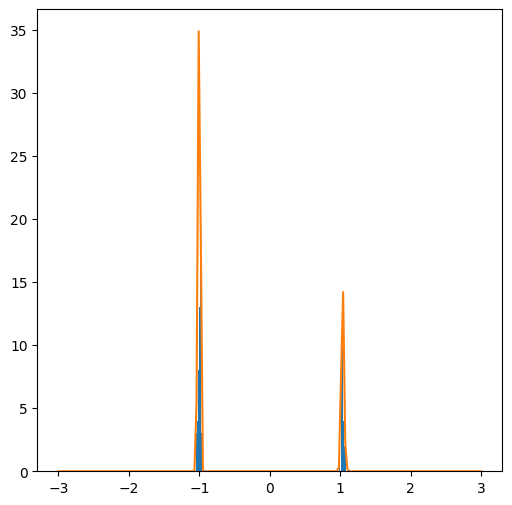

In [42]:
plt.figure(figsize = (6,6))
hist = plt.hist(samples.detach().numpy(), bins = 200)
plot_1d_unormalized_function(lambda theta : torch.exp(posterior_log_prob(theta.unsqueeze(-1))).detach(), range = [-3,3], bins = 500)
plt.show()